# import

In [1]:
import pandas as pd
import json

import os
from os.path import join as pjoin
from pandas.io.json import json_normalize


In [2]:
import numpy as np
import scipy

import math
import random
import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg  import svds



# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
plt.rcParams['figure.figsize'] = (12,6)

# Helper functions

In [4]:
def decode_json(df_raw,json_cols):
    df = df_raw.copy()
    for column in json_cols:
        tdf = json_normalize(df[column])
        df = df.drop(columns = [column])
        tdf.columns = [column + '_' + col for col in tdf.columns]
        df = df.merge(tdf, left_index=True, right_index=True)
    return df

In [5]:
# apply this to genres
def pipe_flatten_names(keywords):
    return '|'.join([x['name'] for x in keywords])


def safe_access(container, index_values):
    # return missing value rather than an error upon indexing/key failure
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan
    
    
def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])

# Load data

With movies dataset only we will create recommendation that use content-based method to find similar movies

Later on we will use rating dataset to validate the result by suggest the movies for user, and if that movie has a rated > 3 we will consider it to be a plus

In [6]:
data_root = '../../data/movies/'
os.listdir(data_root)

['tmdb_5000_credits.csv', 'README.md', 'tmdb_5000_movies.csv']

Notice that data contains json columns

In [7]:
json_cols = ['genres', 'keywords','production_companies' ,'production_countries', 'spoken_languages']

json_conv = {col: json.loads for col in json_cols}

movies = pd.read_csv(pjoin(data_root,'tmdb_5000_movies.csv'),
                     parse_dates=['release_date'],
                     converters=json_conv)

In [8]:
json_cols = ['cast', 'crew']

json_conv = {col: json.loads for col in json_cols}

credits = pd.read_csv(pjoin(data_root,'tmdb_5000_credits.csv'),
                     converters=json_conv)

all of json columns

In [9]:
json_cols = ['genres', 'keywords','production_companies' ,'production_countries', 
                 'spoken_languages','cast','crew']

In [10]:
credits.shape,movies.shape

((4803, 4), (4803, 20))

## Merge 2 dataframe in to 1

In [11]:
credits.columns = ['id', 'title', 'cast', 'crew']

In [12]:
df = credits.merge(movies, on='id')
del credits
del movies
df.shape

(4803, 23)

## Data walkthrough

In [13]:
df.columns

Index(['id', 'title_x', 'cast', 'crew', 'budget', 'genres', 'homepage',
       'keywords', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title_y', 'vote_average', 'vote_count'],
      dtype='object')

In [14]:
df.head()

,id,title_x,cast,crew,budget,genres,homepage,keywords,original_language,original_title,...,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title_y,vote_average,vote_count
0,19995,Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...",237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787965087,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,285,Pirates of the Caribbean: At World's End,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de...",300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://disney.go.com/disneypictures/pirates/,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961000000,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,206647,Spectre,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '54805967c3a36829b5002c41', 'de...",245000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.sonypictures.com/movies/spectre/,"[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...",en,Spectre,...,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2015-10-26,880674609,148.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,49026,The Dark Knight Rises,"[{'cast_id': 2, 'character': 'Bruce Wayne / Ba...","[{'credit_id': '52fe4781c3a36847f81398c3', 'de...",250000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",http://www.thedarkknightrises.com/,"[{'id': 849, 'name': 'dc comics'}, {'id': 853,...",en,The Dark Knight Rises,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-07-16,1084939099,165.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,49529,John Carter,"[{'cast_id': 5, 'character': 'John Carter', 'c...","[{'credit_id': '52fe479ac3a36847f813eaa3', 'de...",260000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://movies.disney.com/john-carter,"[{'id': 818, 'name': 'based on novel'}, {'id':...",en,John Carter,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-03-07,284139100,132.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


There are many json columns and each of these json has more than 1 value

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 23 columns):
id                      4803 non-null int64
title_x                 4803 non-null object
cast                    4803 non-null object
crew                    4803 non-null object
budget                  4803 non-null int64
genres                  4803 non-null object
homepage                1712 non-null object
keywords                4803 non-null object
original_language       4803 non-null object
original_title          4803 non-null object
overview                4800 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
release_date            4802 non-null datetime64[ns]
revenue                 4803 non-null int64
runtime                 4801 non-null float64
spoken_languages        4803 non-null object
status                  4803 non-null object
tagline                 3959 no

homepage missing so many values

In [16]:
for col in df.columns:
    print(col)
    print(df[col].iloc[0])
    print('-'*100)

id
19995
----------------------------------------------------------------------------------------------------
title_x
Avatar
----------------------------------------------------------------------------------------------------
cast
[{'cast_id': 242, 'character': 'Jake Sully', 'credit_id': '5602a8a7c3a3685532001c9a', 'gender': 2, 'id': 65731, 'name': 'Sam Worthington', 'order': 0}, {'cast_id': 3, 'character': 'Neytiri', 'credit_id': '52fe48009251416c750ac9cb', 'gender': 1, 'id': 8691, 'name': 'Zoe Saldana', 'order': 1}, {'cast_id': 25, 'character': 'Dr. Grace Augustine', 'credit_id': '52fe48009251416c750aca39', 'gender': 1, 'id': 10205, 'name': 'Sigourney Weaver', 'order': 2}, {'cast_id': 4, 'character': 'Col. Quaritch', 'credit_id': '52fe48009251416c750ac9cf', 'gender': 2, 'id': 32747, 'name': 'Stephen Lang', 'order': 3}, {'cast_id': 5, 'character': 'Trudy Chacon', 'credit_id': '52fe48009251416c750ac9d3', 'gender': 1, 'id': 17647, 'name': 'Michelle Rodriguez', 'order': 4}, {'cast_id': 8

In [17]:
df.head()

,id,title_x,cast,crew,budget,genres,homepage,keywords,original_language,original_title,...,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title_y,vote_average,vote_count
0,19995,Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...",237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787965087,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,285,Pirates of the Caribbean: At World's End,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de...",300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://disney.go.com/disneypictures/pirates/,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961000000,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,206647,Spectre,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '54805967c3a36829b5002c41', 'de...",245000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.sonypictures.com/movies/spectre/,"[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...",en,Spectre,...,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2015-10-26,880674609,148.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,49026,The Dark Knight Rises,"[{'cast_id': 2, 'character': 'Bruce Wayne / Ba...","[{'credit_id': '52fe4781c3a36847f81398c3', 'de...",250000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",http://www.thedarkknightrises.com/,"[{'id': 849, 'name': 'dc comics'}, {'id': 853,...",en,The Dark Knight Rises,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-07-16,1084939099,165.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,49529,John Carter,"[{'cast_id': 5, 'character': 'John Carter', 'c...","[{'credit_id': '52fe479ac3a36847f813eaa3', 'de...",260000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://movies.disney.com/john-carter,"[{'id': 818, 'name': 'based on novel'}, {'id':...",en,John Carter,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-03-07,284139100,132.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


## Data engineering 

In [18]:
df.head()

,id,title_x,cast,crew,budget,genres,homepage,keywords,original_language,original_title,...,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title_y,vote_average,vote_count
0,19995,Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...",237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787965087,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,285,Pirates of the Caribbean: At World's End,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de...",300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://disney.go.com/disneypictures/pirates/,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961000000,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,206647,Spectre,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '54805967c3a36829b5002c41', 'de...",245000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.sonypictures.com/movies/spectre/,"[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...",en,Spectre,...,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2015-10-26,880674609,148.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,49026,The Dark Knight Rises,"[{'cast_id': 2, 'character': 'Bruce Wayne / Ba...","[{'credit_id': '52fe4781c3a36847f81398c3', 'de...",250000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",http://www.thedarkknightrises.com/,"[{'id': 849, 'name': 'dc comics'}, {'id': 853,...",en,The Dark Knight Rises,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-07-16,1084939099,165.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,49529,John Carter,"[{'cast_id': 5, 'character': 'John Carter', 'c...","[{'credit_id': '52fe479ac3a36847f813eaa3', 'de...",260000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://movies.disney.com/john-carter,"[{'id': 818, 'name': 'based on novel'}, {'id':...",en,John Carter,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2012-03-07,284139100,132.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


### Movie realease year

In [19]:
df.release_date.head()

0   2009-12-10
1   2007-05-19
2   2015-10-26
3   2012-07-16
4   2012-03-07
Name: release_date, dtype: datetime64[ns]

In [20]:
#df_release_year = df.release_date.year
df['release_year'] = df['release_date'].apply(lambda x : x.year)
del df['release_date']

### Country

In [21]:
df['production_countries'].head()

0    [{'iso_3166_1': 'US', 'name': 'United States o...
1    [{'iso_3166_1': 'US', 'name': 'United States o...
2    [{'iso_3166_1': 'GB', 'name': 'United Kingdom'...
3    [{'iso_3166_1': 'US', 'name': 'United States o...
4    [{'iso_3166_1': 'US', 'name': 'United States o...
Name: production_countries, dtype: object

In [22]:
df['production_country_1'] = df['production_countries'].apply(lambda x: safe_access(x, [0, 'iso_3166_1']))
df['production_country_2'] = df['production_countries'].apply(lambda x: safe_access(x, [1, 'iso_3166_1']))
del df['production_countries']

### cast

In [23]:
df['cast'].head()

0    [{'cast_id': 242, 'character': 'Jake Sully', '...
1    [{'cast_id': 4, 'character': 'Captain Jack Spa...
2    [{'cast_id': 1, 'character': 'James Bond', 'cr...
3    [{'cast_id': 2, 'character': 'Bruce Wayne / Ba...
4    [{'cast_id': 5, 'character': 'John Carter', 'c...
Name: cast, dtype: object

TODO : try to add number of actors and actress

In [24]:
df['number_of_cast'] = df.cast.apply(lambda x: len(x) )
del df['cast']

### Genres

In [25]:
df['genres'].head()

0    [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...
1    [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...
2    [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...
3    [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...
4    [{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...
Name: genres, dtype: object

In [26]:
df['genres'] = df['genres'].apply(pipe_flatten_names)

### Keywords

In [27]:
df['keywords'].head()

0    [{'id': 1463, 'name': 'culture clash'}, {'id':...
1    [{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...
2    [{'id': 470, 'name': 'spy'}, {'id': 818, 'name...
3    [{'id': 849, 'name': 'dc comics'}, {'id': 853,...
4    [{'id': 818, 'name': 'based on novel'}, {'id':...
Name: keywords, dtype: object

In [28]:
df['keywords'] = df['keywords'].apply(pipe_flatten_names)

### Director

In [29]:
df['crew'].iloc[0]

[{'credit_id': '52fe48009251416c750aca23',
  'department': 'Editing',
  'gender': 0,
  'id': 1721,
  'job': 'Editor',
  'name': 'Stephen E. Rivkin'},
 {'credit_id': '539c47ecc3a36810e3001f87',
  'department': 'Art',
  'gender': 2,
  'id': 496,
  'job': 'Production Design',
  'name': 'Rick Carter'},
 {'credit_id': '54491c89c3a3680fb4001cf7',
  'department': 'Sound',
  'gender': 0,
  'id': 900,
  'job': 'Sound Designer',
  'name': 'Christopher Boyes'},
 {'credit_id': '54491cb70e0a267480001bd0',
  'department': 'Sound',
  'gender': 0,
  'id': 900,
  'job': 'Supervising Sound Editor',
  'name': 'Christopher Boyes'},
 {'credit_id': '539c4a4cc3a36810c9002101',
  'department': 'Production',
  'gender': 1,
  'id': 1262,
  'job': 'Casting',
  'name': 'Mali Finn'},
 {'credit_id': '5544ee3b925141499f0008fc',
  'department': 'Sound',
  'gender': 2,
  'id': 1729,
  'job': 'Original Music Composer',
  'name': 'James Horner'},
 {'credit_id': '52fe48009251416c750ac9c3',
  'department': 'Directing',
  

In [30]:
df['director_name'] = df['crew'].apply(get_director)
del df['crew']

### Spoken languages

In [31]:
del df['spoken_languages']

### Rescale

In [32]:
df.revenue = np.log1p(df.revenue)
df.budget = np.log1p(df.budget)

## Visualizing

In [33]:
df.head()

,id,title_x,budget,genres,homepage,keywords,original_language,original_title,overview,popularity,...,status,tagline,title_y,vote_average,vote_count,release_year,production_country_1,production_country_2,number_of_cast,director_name
0,19995,Avatar,19.283571,Action|Adventure|Fantasy|Science Fiction,http://www.avatarmovie.com/,culture clash|future|space war|space colony|so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,Released,Enter the World of Pandora.,Avatar,7.2,11800,2009.0,US,GB,83,James Cameron
1,285,Pirates of the Caribbean: At World's End,19.519293,Adventure|Fantasy|Action,http://disney.go.com/disneypictures/pirates/,ocean|drug abuse|exotic island|east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,2007.0,US,NaN,34,Gore Verbinski
2,206647,Spectre,19.316769,Action|Adventure|Crime,http://www.sonypictures.com/movies/spectre/,spy|based on novel|secret agent|sequel|mi6|bri...,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,Released,A Plan No One Escapes,Spectre,6.3,4466,2015.0,GB,US,83,Sam Mendes
3,49026,The Dark Knight Rises,19.336971,Action|Crime|Drama|Thriller,http://www.thedarkknightrises.com/,dc comics|crime fighter|terrorist|secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,Released,The Legend Ends,The Dark Knight Rises,7.6,9106,2012.0,US,NaN,158,Christopher Nolan
4,49529,John Carter,19.376192,Action|Adventure|Science Fiction,http://movies.disney.com/john-carter,based on novel|mars|medallion|space travel|pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,Released,"Lost in our world, found in another.",John Carter,6.1,2124,2012.0,US,NaN,27,Andrew Stanton


### Null values status

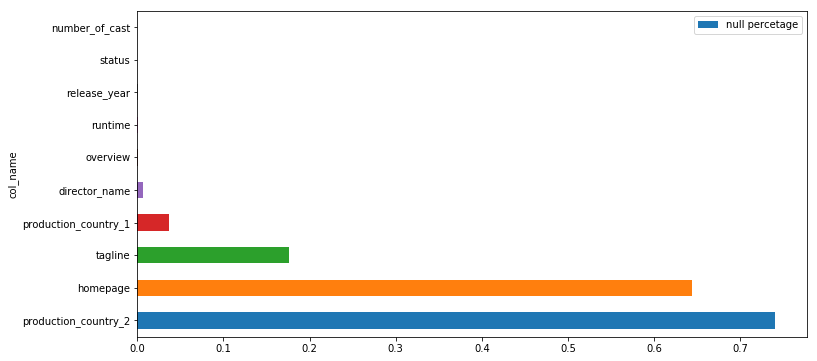

In [34]:
null_df = pd.DataFrame(columns=['col_name','null count','null percetage'])
for col in df.columns:
    null_count = df[col].isnull().sum()
    null_percnt = null_count/len(df[col])
    null_df.loc[col] = [col,null_count,null_percnt]
    
null_df = null_df.sort_values(by='null percetage',ascending=False)
null_df[:10].plot(y='null percetage',x='col_name',kind='barh')

### Budget

Text(0.5, 0, 'Budget (m$)')

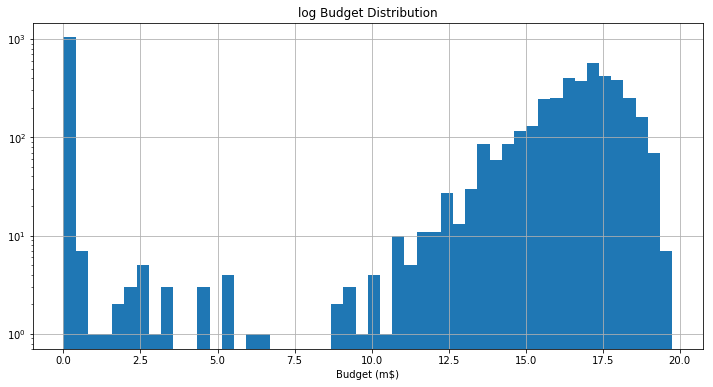

In [35]:
(df.budget).hist(bins=50,log=True)
plt.title('log Budget Distribution')
plt.xlabel('Budget (m$)')

Film country production

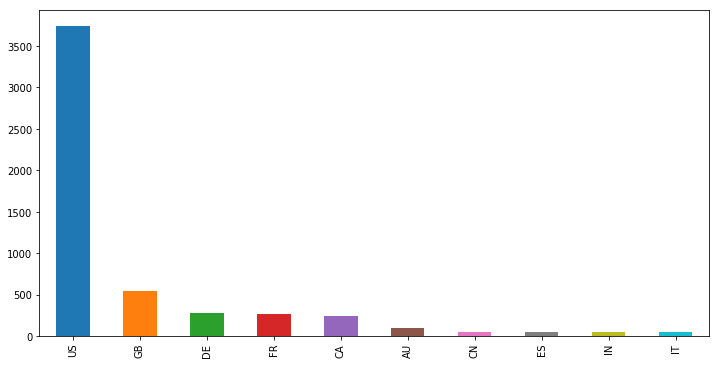

In [36]:
all_country = pd.concat([df.production_country_1,df.production_country_2])
all_country.value_counts()[:10].plot(kind='bar')

Most of the film come from US

### Revenue

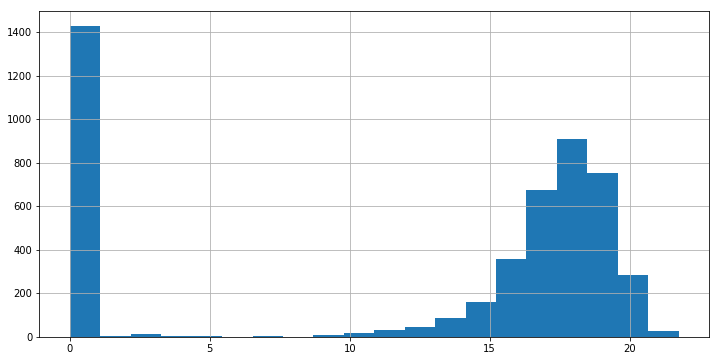

In [37]:
df.revenue.hist(bins=20)

In [45]:
print('# of data with 0 revenue' ,df[df.revenue==0].revenue.count())
print('# of Budget with 0 revenue' ,df[df.budget==0].budget.count())

# of data with 0 revenue 1427
# of Budget with 0 revenue 1037


Some of revenue is really low, (a movie has 4$ revenue) 

We can't trust this attributes



In [40]:
df_revenue_budget_none_zero = df[(df.revenue>0) & (df.budget>0)]
df_revenue_budget_none_zero.shape

(3229, 23)

Let's look at how budget relate to revenue

Text(0, 0.5, 'Revenue (m$)')

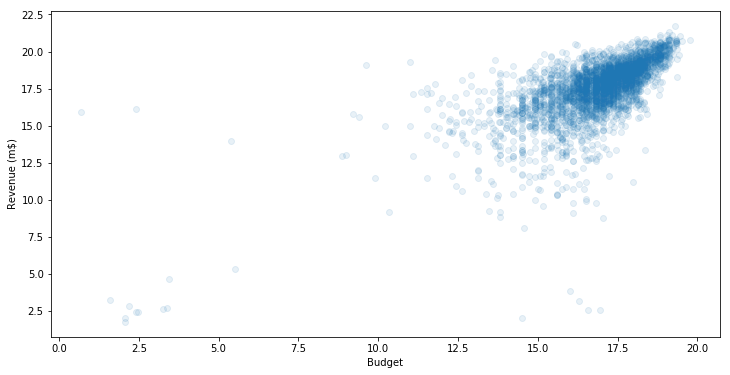

In [41]:
plt.scatter(x=df_revenue_budget_none_zero.budget,
            y=df_revenue_budget_none_zero.revenue,alpha='.1')
plt.xlabel('Budget')
plt.ylabel('Revenue (m$)')

Seems like it has a linear relationship between budget and revenue

How does revenue relate to Rating?

Text(0, 0.5, 'Average vote')

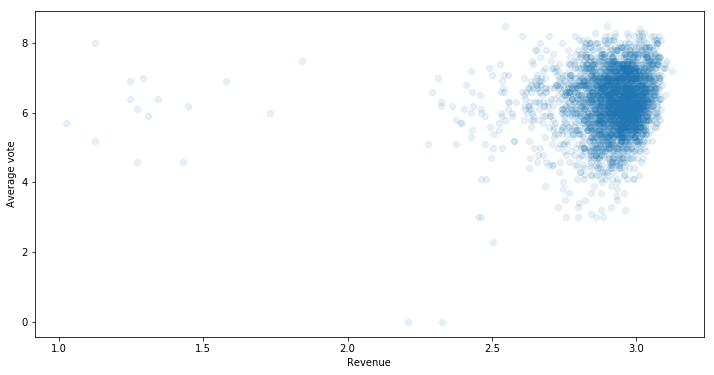

In [42]:
plt.scatter(x=np.log1p(df_revenue_budget_none_zero.revenue),
            y=df_revenue_budget_none_zero.vote_average,alpha=.1)
plt.xlabel('Revenue')
plt.ylabel('Average vote')

The higher the vote the more revenue

But still, some movies has high vote but badly low revenue

How about year?

Text(0, 0.5, 'Year')

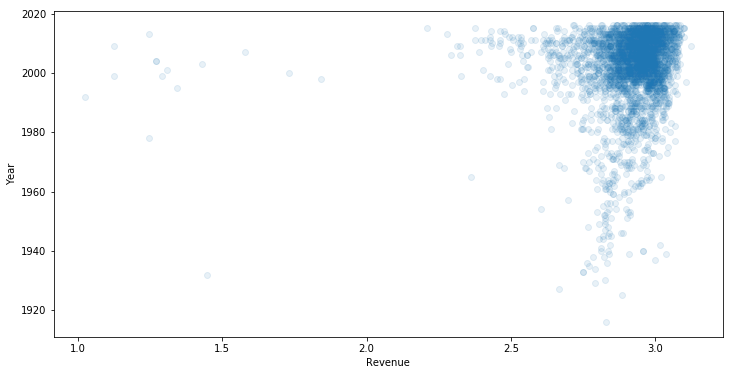

In [43]:
plt.scatter(x=np.log1p(df_revenue_budget_none_zero.revenue),
            y=df_revenue_budget_none_zero.release_year,alpha=.1)
plt.xlabel('Revenue')
plt.ylabel('Year')

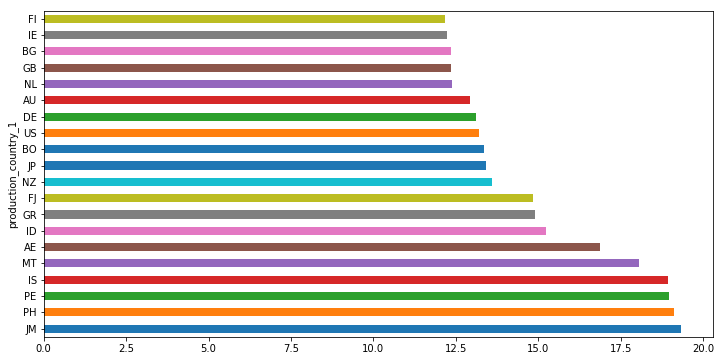

In [84]:
df.groupby('production_country_1').revenue.mean().sort_values(ascending=False)[:20].plot(kind='barh')

Us has low avg revenue

In [147]:
# get mean revenue by country
revenue_by_country = df.groupby('production_country_1').revenue.mean().to_frame().reset_index()
revenue_by_country.columns = ['production_country_1','mean_revenue']

# get movies count by country
film_count_by_country = df.groupby('production_country_1').id.count().to_frame().reset_index()
film_count_by_country.columns = ['production_country_1','count']

# merge the 2
df_ = pd.merge(revenue_by_country,film_count_by_country,on='production_country_1')

Text(0, 0.5, 'Mean revenue')

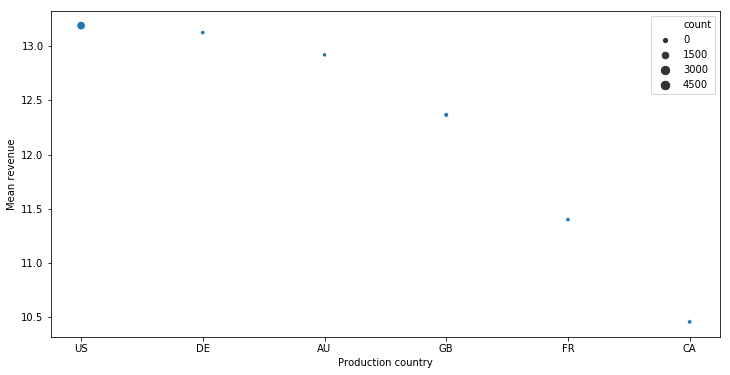

In [149]:
# just get the country with more than movies
df_ = df_[df_['count']>50]
df_ = df_.sort_values('mean_revenue',ascending=False)
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
sns.scatterplot(x='production_country_1',y='mean_revenue',size='count',
                data=df_.iloc[:20],palette=cmap)
plt.xlabel('Production country')
plt.ylabel('Mean revenue')

US are truely a country of movie